In [3]:
from pathlib import Path
import json
import numpy as np
import pandas as pd

CLUSTERS = [0, 1]

# Prediction folders
PRED_MLP_DIR = Path("preds_mlp")
PRED_RF_DIR  = Path("preds_rf")
PRED_REG_DIR = Path("preds_regressor")

# TS daily preds (leak-free notebook output)
PRED_TS_DIR  = Path("preds_ts_daily")  # ts_daily_cluster_{c}_preds.parquet

# Weight artifacts that already exist
W_MLP = Path("artifacts_mlp/mlp_general_weight.json")
W_RF  = Path("artifacts_rf/rf_general_weight.json")
W_REG = Path("artifacts_regressor/reg_general_weight.json")

# We'll compute these from VAL if JSONs are missing
W_SARIMAX = Path("artifacts_sarimax_daily/sarimax_general_weight.json")
W_PROPHET = Path("artifacts_prophet_daily/prophet_general_weight.json")

OUT_DIR = Path("ensemble_outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)

EPS = 1e-6


In [4]:
def load_weight_json(path: Path) -> dict:
    with open(path, "r") as f:
        return json.load(f)

def get_raw_weight(w):
    if "general_weight_raw" in w:
        return float(w["general_weight_raw"])
    if "general_mae_val_oct" in w:
        return 1.0 / (float(w["general_mae_val_oct"]) + EPS)
    if "mae_val_oct" in w:
        return 1.0 / (float(w["mae_val_oct"]) + EPS)
    raise ValueError(f"Missing weight fields in {w}")

# --- Load existing weights (mlp/rf/reg) ---
w_mlp = load_weight_json(W_MLP)
w_rf  = load_weight_json(W_RF)
w_reg = load_weight_json(W_REG)

raw = {
    "mlp": get_raw_weight(w_mlp),
    "rf":  get_raw_weight(w_rf),
    "reg": get_raw_weight(w_reg),
}

# --- Compute SARIMAX/Prophet weights from VAL (October) if JSONs missing ---
def compute_ts_val_mae_from_preds(clusters):
    frames = []
    for c in clusters:
        p = PRED_TS_DIR / f"ts_daily_cluster_{c}_preds.parquet"
        if not p.exists():
            raise FileNotFoundError(f"Missing TS preds parquet: {p}")
        frames.append(pd.read_parquet(p))
    tsdf = pd.concat(frames, ignore_index=True)

    # must have split == "val"
    if "split" not in tsdf.columns:
        raise ValueError("TS preds parquet missing 'split' column.")
    val = tsdf[tsdf["split"] == "val"].copy()
    if len(val) == 0:
        raise ValueError("No VAL rows found in TS preds (split=='val').")

    # These columns are from the safe TS notebook
    need_cols = {"ae_pickups_sarimax", "ae_dropoffs_prophet"}
    missing = need_cols - set(val.columns)
    if missing:
        raise ValueError(f"TS VAL missing columns: {missing}")

    mae_pick_sarimax = float(val["ae_pickups_sarimax"].mean())
    mae_drop_prophet = float(val["ae_dropoffs_prophet"].mean())

    return mae_pick_sarimax, mae_drop_prophet

# SARIMAX weight (based on pickups MAE in Oct)
# Prophet weight (based on dropoffs MAE in Oct)
if W_SARIMAX.exists() and W_PROPHET.exists():
    w_sar = load_weight_json(W_SARIMAX)
    w_pro = load_weight_json(W_PROPHET)
    raw["sarimax"] = get_raw_weight(w_sar)
    raw["prophet"] = get_raw_weight(w_pro)
else:
    mae_pick_sarimax, mae_drop_prophet = compute_ts_val_mae_from_preds(CLUSTERS)

    raw["sarimax"] = 1.0 / (mae_pick_sarimax + EPS)
    raw["prophet"] = 1.0 / (mae_drop_prophet + EPS)

    # Optional: save for reproducibility
    W_SARIMAX.parent.mkdir(parents=True, exist_ok=True)
    W_PROPHET.parent.mkdir(parents=True, exist_ok=True)

    sar_json = {
        "model": "sarimax",
        "general_mae_val_oct": mae_pick_sarimax,
        "general_weight_raw": raw["sarimax"],
        "note": "Computed from preds_ts_daily VAL (Oct) using ae_pickups_sarimax mean."
    }
    pro_json = {
        "model": "prophet",
        "general_mae_val_oct": mae_drop_prophet,
        "general_weight_raw": raw["prophet"],
        "note": "Computed from preds_ts_daily VAL (Oct) using ae_dropoffs_prophet mean."
    }

    W_SARIMAX.write_text(json.dumps(sar_json, indent=2))
    W_PROPHET.write_text(json.dumps(pro_json, indent=2))

    print("[INFO] Saved missing TS weight jsons:")
    print(" -", W_SARIMAX)
    print(" -", W_PROPHET)

# --- Show weights ---
s_all = sum(raw.values())
weights_all = {k: v/s_all for k,v in raw.items()}

print("Raw weights:", raw)
print("Normalized weights (all):", weights_all)

# Target-specific normalization
s_pick = raw["mlp"] + raw["rf"] + raw["reg"] + raw["sarimax"]
weights_pickups = {k: raw[k]/s_pick for k in ["mlp","rf","reg","sarimax"]}

s_drop = raw["mlp"] + raw["rf"] + raw["reg"] + raw["prophet"]
weights_dropoffs = {k: raw[k]/s_drop for k in ["mlp","rf","reg","prophet"]}

print("\nNormalized weights (pickups):", weights_pickups)
print("Normalized weights (dropoffs):", weights_dropoffs)


[INFO] Saved missing TS weight jsons:
 - artifacts_sarimax_daily/sarimax_general_weight.json
 - artifacts_prophet_daily/prophet_general_weight.json
Raw weights: {'mlp': 0.04454154084747765, 'rf': 0.08429954322659551, 'reg': 0.06369525872128058, 'sarimax': 0.05623514944611973, 'prophet': 0.06970857753188357}
Normalized weights (all): {'mlp': 0.1398566035205128, 'rf': 0.2646933080823123, 'reg': 0.19999762863217352, 'sarimax': 0.17657352777565916, 'prophet': 0.21887893198934216}

Normalized weights (pickups): {'mlp': 0.17904600099533424, 'rf': 0.33886335796373723, 'reg': 0.25603921955596864, 'sarimax': 0.2260514214849598}
Normalized weights (dropoffs): {'mlp': 0.16984710625432642, 'rf': 0.3214534837182125, 'reg': 0.24288462343445838, 'prophet': 0.2658147865930026}


In [5]:
def load_preds_for_model_cluster(model: str, cluster_id: int) -> pd.DataFrame:
    """
    model in {"mlp","rf","reg","ts"}.
    Returns a standardized df with:
      date, hour, cluster_id, split,
      y_true_pickups, y_true_dropoffs,
      prediction columns depending on model.
    """
    if model == "mlp":
        path = PRED_MLP_DIR / f"mlp_cluster_{cluster_id}_preds.parquet"
        df = pd.read_parquet(path)

    elif model == "rf":
        path = PRED_RF_DIR / f"rf_cluster_{cluster_id}_preds.parquet"
        df = pd.read_parquet(path)

    elif model == "reg":
        path = PRED_REG_DIR / f"reg_cluster_{cluster_id}_preds.parquet"
        df = pd.read_parquet(path)

    elif model == "ts":
        path = PRED_TS_DIR / f"ts_daily_cluster_{cluster_id}_preds.parquet"
        df = pd.read_parquet(path)

        # Ensure naming matches our ensemble convention
        # expected cols from your safe notebook:
        # y_pred_sarimax_pickups, y_pred_prophet_dropoffs
        # (and y_true_pickups, y_true_dropoffs already exist)
    else:
        raise ValueError("model must be one of: mlp, rf, reg, ts")

    needed_keys = {"date","hour","cluster_id","split","y_true_pickups","y_true_dropoffs"}
    missing = needed_keys - set(df.columns)
    if missing:
        raise ValueError(f"{model} cluster {cluster_id} missing columns: {missing}")

    df = df.copy()
    df["date"] = pd.to_datetime(df["date"]).dt.normalize()
    df["hour"] = df["hour"].astype(int)
    df["cluster_id"] = df["cluster_id"].astype(int)

    # Keep standard keys + all y_pred_* columns
    keep = ["date","hour","cluster_id","split","y_true_pickups","y_true_dropoffs"]
    pred_cols = [c for c in df.columns if c.startswith("y_pred_")]
    keep = keep + pred_cols

    return df[keep].copy()


In [6]:
dfs = []
for cid in CLUSTERS:
    df_mlp = load_preds_for_model_cluster("mlp", cid)
    df_rf  = load_preds_for_model_cluster("rf", cid)
    df_reg = load_preds_for_model_cluster("reg", cid)
    df_ts  = load_preds_for_model_cluster("ts", cid)

    keys = ["date","hour","cluster_id","split","y_true_pickups","y_true_dropoffs"]

    merged = df_mlp.merge(df_rf, on=keys, how="inner") \
                   .merge(df_reg, on=keys, how="inner") \
                   .merge(df_ts, on=keys, how="inner")
    dfs.append(merged)

all_df = pd.concat(dfs, ignore_index=True)

print("[INFO] merged shape:", all_df.shape)
print("[INFO] columns:", list(all_df.columns))
all_df.head()


[INFO] merged shape: (4416, 14)
[INFO] columns: ['date', 'hour', 'cluster_id', 'split', 'y_true_pickups', 'y_true_dropoffs', 'y_pred_mlp_pickups', 'y_pred_mlp_dropoffs', 'y_pred_rf_pickups', 'y_pred_rf_dropoffs', 'y_pred_reg_pickups', 'y_pred_reg_dropoffs', 'y_pred_sarimax_pickups', 'y_pred_prophet_dropoffs']


,date,hour,cluster_id,split,y_true_pickups,y_true_dropoffs,y_pred_mlp_pickups,y_pred_mlp_dropoffs,y_pred_rf_pickups,y_pred_rf_dropoffs,y_pred_reg_pickups,y_pred_reg_dropoffs,y_pred_sarimax_pickups,y_pred_prophet_dropoffs
0,2018-10-01,0,0,val,15.0,15.0,10.749871,29.642841,10.499311,14.895329,16.668694,24.406998,16.343159,18.783953
1,2018-10-01,1,0,val,6.0,11.0,12.341836,19.968367,7.171750,10.295126,9.979333,8.354006,9.754439,9.974062
2,2018-10-01,2,0,val,3.0,3.0,10.862610,11.952774,2.371601,3.010912,0.806574,5.001746,2.230385,5.888411
3,2018-10-01,3,0,val,1.0,0.0,1.787076,5.375502,2.039691,2.310769,0.252949,1.076300,0.840597,5.387385
4,2018-10-01,4,0,val,2.0,3.0,5.874234,6.608563,1.777519,1.716204,-0.207398,-0.421543,0.000000,4.569315


In [7]:
required_pred_cols = [
    "y_pred_mlp_pickups", "y_pred_mlp_dropoffs",
    "y_pred_rf_pickups",  "y_pred_rf_dropoffs",
    "y_pred_reg_pickups", "y_pred_reg_dropoffs",
    "y_pred_sarimax_pickups",          # NEW
    "y_pred_prophet_dropoffs",          # NEW
]

missing = [c for c in required_pred_cols if c not in all_df.columns]
if missing:
    raise ValueError(f"Missing required prediction columns: {missing}")

print("Available splits:", all_df["split"].unique())

null_counts = all_df[required_pred_cols].isna().sum().sort_values(ascending=False)
print("Null counts in preds:\n", null_counts)


Available splits: ['val' 'test']
Null counts in preds:
 y_pred_mlp_pickups         0
y_pred_mlp_dropoffs        0
y_pred_rf_pickups          0
y_pred_rf_dropoffs         0
y_pred_reg_pickups         0
y_pred_reg_dropoffs        0
y_pred_sarimax_pickups     0
y_pred_prophet_dropoffs    0
dtype: int64


In [8]:
wp = weights_pickups
wd = weights_dropoffs

all_df["y_pred_ens_pickups"] = (
    wp["mlp"]    * all_df["y_pred_mlp_pickups"] +
    wp["rf"]     * all_df["y_pred_rf_pickups"]  +
    wp["reg"]    * all_df["y_pred_reg_pickups"] +
    wp["sarimax"]* all_df["y_pred_sarimax_pickups"]
)

all_df["y_pred_ens_dropoffs"] = (
    wd["mlp"]     * all_df["y_pred_mlp_dropoffs"] +
    wd["rf"]      * all_df["y_pred_rf_dropoffs"]  +
    wd["reg"]     * all_df["y_pred_reg_dropoffs"] +
    wd["prophet"] * all_df["y_pred_prophet_dropoffs"]
)

all_df["y_pred_ens_pickups"] = all_df["y_pred_ens_pickups"].clip(lower=0)
all_df["y_pred_ens_dropoffs"] = all_df["y_pred_ens_dropoffs"].clip(lower=0)

all_df["ae_pickups_ens"] = (all_df["y_true_pickups"] - all_df["y_pred_ens_pickups"]).abs()
all_df["ae_dropoffs_ens"] = (all_df["y_true_dropoffs"] - all_df["y_pred_ens_dropoffs"]).abs()
all_df["ae_mean_ens"] = 0.5 * (all_df["ae_pickups_ens"] + all_df["ae_dropoffs_ens"])

all_df.head()


,date,hour,cluster_id,split,y_true_pickups,y_true_dropoffs,y_pred_mlp_pickups,y_pred_mlp_dropoffs,y_pred_rf_pickups,y_pred_rf_dropoffs,y_pred_reg_pickups,y_pred_reg_dropoffs,y_pred_sarimax_pickups,y_pred_prophet_dropoffs,y_pred_ens_pickups,y_pred_ens_dropoffs,ae_pickups_ens,ae_dropoffs_ens,ae_mean_ens
0,2018-10-01,0,0,val,15.0,15.0,10.749871,29.642841,10.499311,14.895329,16.668694,24.406998,16.343159,18.783953,13.444787,20.744043,1.555213,5.744043,3.649628
1,2018-10-01,1,0,val,6.0,11.0,12.341836,19.968367,7.171750,10.295126,9.979333,8.354006,9.754439,9.974062,9.400105,11.381286,3.400105,0.381286,1.890696
2,2018-10-01,2,0,val,3.0,3.0,10.862610,11.952774,2.371601,3.010912,0.806574,5.001746,2.230385,5.888411,3.459252,5.778086,0.459252,2.778086,1.618669
3,2018-10-01,3,0,val,1.0,0.0,1.787076,5.375502,2.039691,2.310769,0.252949,1.076300,0.840597,5.387385,1.265928,3.349282,0.265928,3.349282,1.807605
4,2018-10-01,4,0,val,2.0,3.0,5.874234,6.608563,1.777519,1.716204,-0.207398,-0.421543,0.000000,4.569315,1.600992,2.786330,0.399008,0.213670,0.306339


In [9]:
def compute_model_mae(df, pred_pick_col=None, pred_drop_col=None, name="model"):
    out = {}
    if pred_pick_col is not None:
        ae_pick = (df["y_true_pickups"] - df[pred_pick_col]).abs()
        out[f"mae_pickups_{name}"] = ae_pick.mean()
    if pred_drop_col is not None:
        ae_drop = (df["y_true_dropoffs"] - df[pred_drop_col]).abs()
        out[f"mae_dropoffs_{name}"] = ae_drop.mean()
    if pred_pick_col is not None and pred_drop_col is not None:
        out[f"mae_mean_{name}"] = 0.5 * (out[f"mae_pickups_{name}"] + out[f"mae_dropoffs_{name}"])
    return pd.Series(out)

metrics_all = pd.concat([
    compute_model_mae(all_df, "y_pred_mlp_pickups","y_pred_mlp_dropoffs","mlp"),
    compute_model_mae(all_df, "y_pred_rf_pickups","y_pred_rf_dropoffs","rf"),
    compute_model_mae(all_df, "y_pred_reg_pickups","y_pred_reg_dropoffs","reg"),
    compute_model_mae(all_df, "y_pred_sarimax_pickups", None, "sarimax"),
    compute_model_mae(all_df, None, "y_pred_prophet_dropoffs", "prophet"),
    compute_model_mae(all_df, "y_pred_ens_pickups","y_pred_ens_dropoffs","ens"),
])

print(metrics_all.sort_index())


mae_dropoffs_ens        13.554806
mae_dropoffs_mlp        18.965023
mae_dropoffs_prophet    15.972128
mae_dropoffs_reg        15.286289
mae_dropoffs_rf         15.514196
mae_mean_ens            13.500872
mae_mean_mlp            19.327017
mae_mean_reg            15.649339
mae_mean_rf             14.832211
mae_pickups_ens         13.446937
mae_pickups_mlp         19.689011
mae_pickups_reg         16.012388
mae_pickups_rf          14.150227
mae_pickups_sarimax     16.861085
dtype: float64


In [10]:
def summarize(df, label):
    out = {
        "rows": len(df),
        "mae_pickups": float(df["ae_pickups_ens"].mean()),
        "mae_dropoffs": float(df["ae_dropoffs_ens"].mean()),
        "mae_mean": float(df["ae_mean_ens"].mean()),
    }
    print(f"\n=== Ensemble summary ({label}) ===")
    for k,v in out.items():
        print(f"{k}: {v:.6f}" if isinstance(v, float) else f"{k}: {v}")
    return out

val_df = all_df[all_df["split"] == "val"].copy()
test_df = all_df[all_df["split"] == "test"].copy()

summarize(val_df, "VAL (October)")
summarize(test_df, "TEST (Nov-Dec)")



=== Ensemble summary (VAL (October)) ===
rows: 1488
mae_pickups: 13.322386
mae_dropoffs: 12.471923
mae_mean: 12.897155

=== Ensemble summary (TEST (Nov-Dec)) ===
rows: 2928
mae_pickups: 13.510234
mae_dropoffs: 14.105124
mae_mean: 13.807679


{'rows': 2928,
 'mae_pickups': 13.510233671093413,
 'mae_dropoffs': 14.105123818629195,
 'mae_mean': 13.807678744861304}

In [11]:
by_cluster = (
    test_df.groupby("cluster_id")[["ae_pickups_ens","ae_dropoffs_ens","ae_mean_ens"]]
    .mean()
    .sort_values("ae_mean_ens")
)
print("\n=== TEST MAE by cluster ===")
print(by_cluster)

by_hour = (
    test_df.groupby("hour")[["ae_pickups_ens","ae_dropoffs_ens","ae_mean_ens"]]
    .mean()
    .sort_index()
)
print("\n=== TEST MAE by hour ===")
print(by_hour)



=== TEST MAE by cluster ===
            ae_pickups_ens  ae_dropoffs_ens  ae_mean_ens
cluster_id                                              
0                 6.915994         7.293397     7.104696
1                20.104474        20.916850    20.510662

=== TEST MAE by hour ===
      ae_pickups_ens  ae_dropoffs_ens  ae_mean_ens
hour                                              
0           2.799292         3.931923     3.365607
1           2.684256         3.348082     3.016169
2           1.921843         2.264048     2.092946
3           1.439970         2.117898     1.778934
4           1.390535         1.625695     1.508115
5           3.464217         3.194466     3.329341
6           9.038496         8.734084     8.886290
7          20.337819        15.399666    17.868743
8          29.459392        21.608475    25.533934
9          17.084198        15.956479    16.520339
10         14.234410        12.819970    13.527190
11         17.099192        15.763112    16.431152
12 

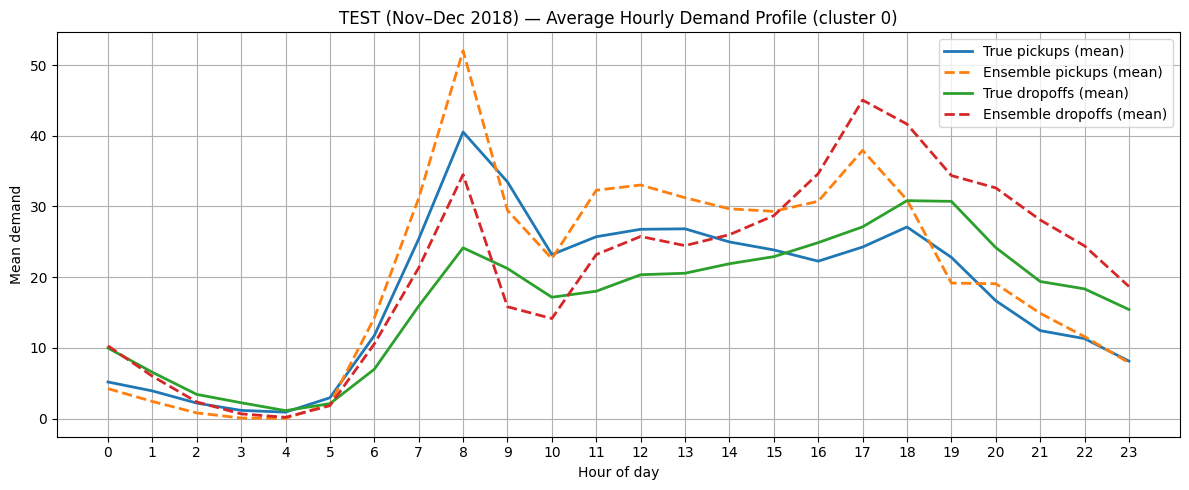

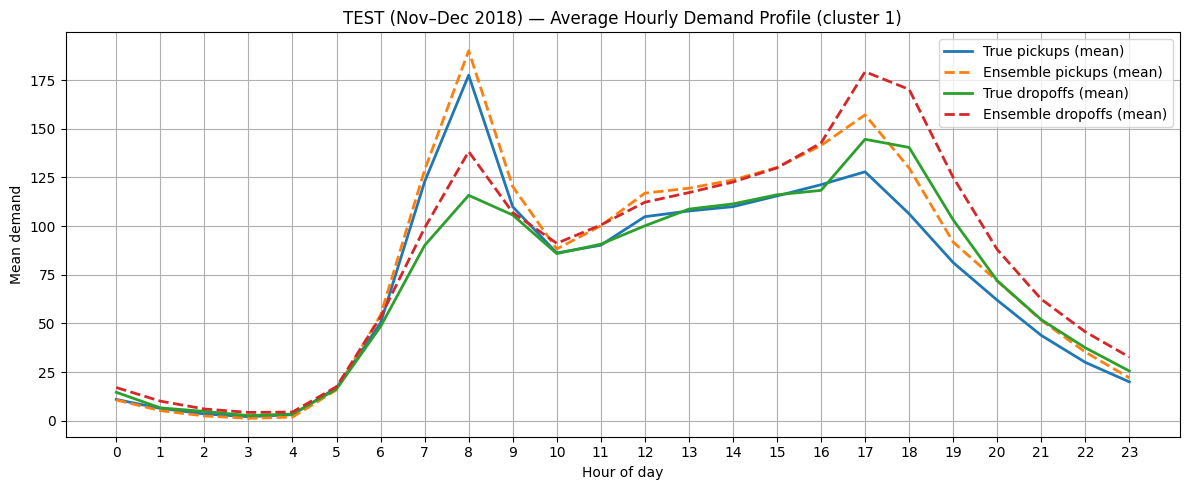

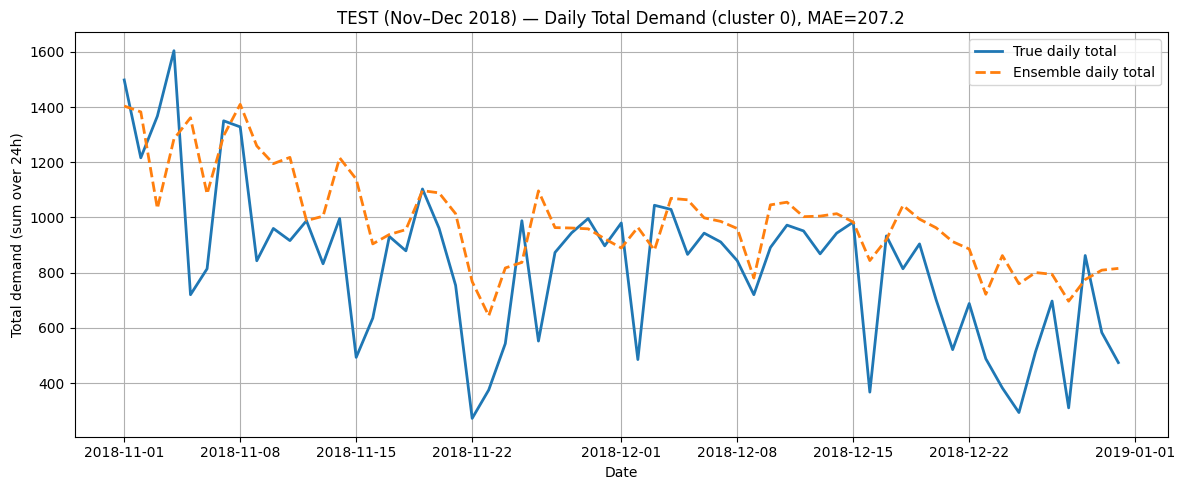

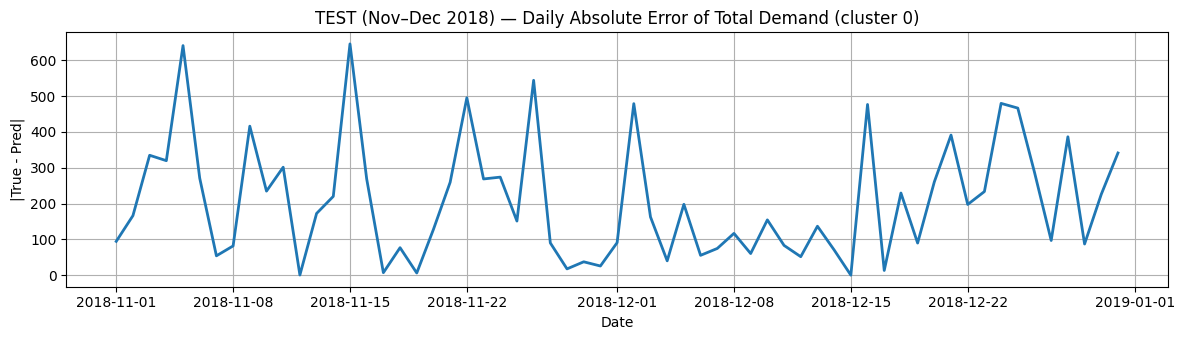

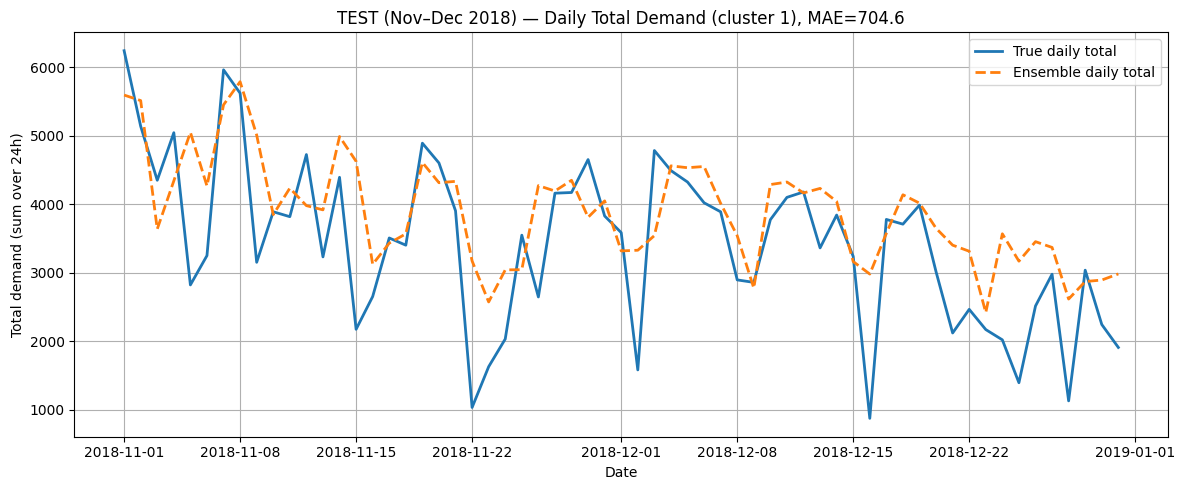

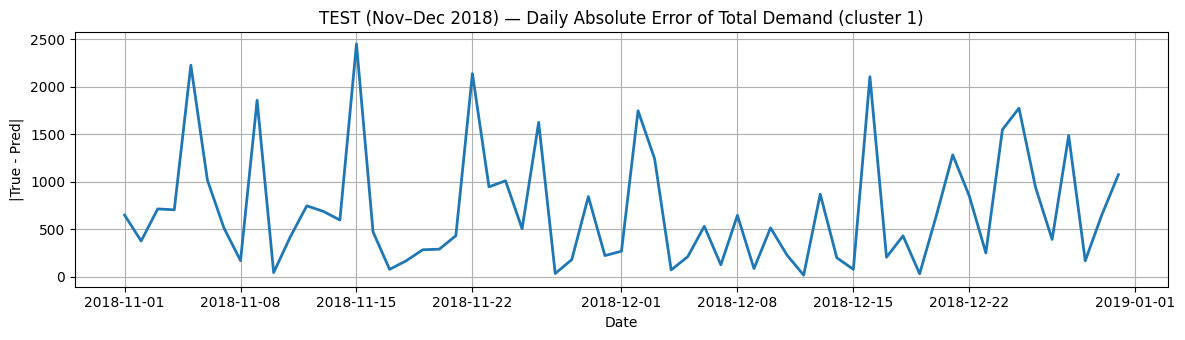

In [13]:
import matplotlib.pyplot as plt

test_df = all_df[all_df["split"] == "test"].copy()

# Ensure totals exist
test_df["y_true_total"] = test_df["y_true_pickups"] + test_df["y_true_dropoffs"]
test_df["y_pred_ens_total"] = test_df["y_pred_ens_pickups"] + test_df["y_pred_ens_dropoffs"]

# -------------------------
# 1) Average hourly profile per cluster (NOT aggregated across clusters)
# -------------------------
for cid in sorted(test_df["cluster_id"].unique()):
    dfc = test_df[test_df["cluster_id"] == cid].copy()

    hour_prof = dfc.groupby("hour").agg(
        true_pickups=("y_true_pickups", "mean"),
        pred_pickups=("y_pred_ens_pickups", "mean"),
        true_dropoffs=("y_true_dropoffs", "mean"),
        pred_dropoffs=("y_pred_ens_dropoffs", "mean"),
    ).sort_index()

    plt.figure(figsize=(12, 5))
    plt.plot(hour_prof.index, hour_prof["true_pickups"], linewidth=2, label="True pickups (mean)")
    plt.plot(hour_prof.index, hour_prof["pred_pickups"], linewidth=2, linestyle="--", label="Ensemble pickups (mean)")
    plt.plot(hour_prof.index, hour_prof["true_dropoffs"], linewidth=2, label="True dropoffs (mean)")
    plt.plot(hour_prof.index, hour_prof["pred_dropoffs"], linewidth=2, linestyle="--", label="Ensemble dropoffs (mean)")

    plt.title(f"TEST (Nov–Dec 2018) — Average Hourly Demand Profile (cluster {cid})")
    plt.xlabel("Hour of day")
    plt.ylabel("Mean demand")
    plt.xticks(range(24))
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


# -------------------------
# 2) Daily totals per cluster (NOT aggregated across clusters)
# -------------------------
for cid in sorted(test_df["cluster_id"].unique()):
    dfc = test_df[test_df["cluster_id"] == cid].copy()

    daily = dfc.groupby("date")[["y_true_total", "y_pred_ens_total"]].sum().sort_index()
    daily["ae_total"] = (daily["y_true_total"] - daily["y_pred_ens_total"]).abs()
    mae_daily = daily["ae_total"].mean()

    plt.figure(figsize=(12, 5))
    plt.plot(daily.index, daily["y_true_total"], linewidth=2, label="True daily total")
    plt.plot(daily.index, daily["y_pred_ens_total"], linewidth=2, linestyle="--", label="Ensemble daily total")

    plt.title(f"TEST (Nov–Dec 2018) — Daily Total Demand (cluster {cid}), MAE={mae_daily:.1f}")
    plt.xlabel("Date")
    plt.ylabel("Total demand (sum over 24h)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 3.5))
    plt.plot(daily.index, daily["ae_total"], linewidth=2)
    plt.title(f"TEST (Nov–Dec 2018) — Daily Absolute Error of Total Demand (cluster {cid})")
    plt.xlabel("Date")
    plt.ylabel("|True - Pred|")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
